<h3>Neural Network</h3>
<h4>Packages Used</h4>
<ul>
    <li>numpy</li>
    <li>matplotlib</li>
    <li>scipy</li>
    <li>pickle</li>
    <li>os</li>
</ul>
<h3>Import necessary packages</h3>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import pickle
import os

In [2]:
plt.rcParams['figure.figsize'] = [10, 8]

<h3>ReadData(data,separator): Helper function to read data</h3>
<h4> Assumes data is of the form X[0], X[1], ..., X[n], Y</h4>
<h5>Where X[i] is a feature and Y is the label</h5> 

In [3]:
def ReadData(data,separator):
    
    XY =  np.genfromtxt(data, delimiter=separator)
    m=XY.shape[0]
    Y=XY[:,-1].reshape(m,1)
    X=XY[:,0:-1]
    return X,Y,m

<h3>Normalize(data): Helper function to Normalize data</h3>

In [4]:
def Normalize(data):
    
    Mu = np.mean(X, axis=0)
    Sigma = np.std(X, axis=0)
    data = ((data-Mu)/Sigma)
    return data, Mu, Sigma

In [5]:
def mapFeature(X1, X2):
# MAPFEATURE Feature mapping function to polynomial features
#
#   MAPFEATURE(X1, X2) maps the two input features
#   to quadratic features used in the regularization exercise.
#
#   Returns a new feature array with more features, comprising of 
#   X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..
#   for a total of 1 + 2 + ... + (degree+1) = ((degree+1) * (degree+2)) / 2 columns
#
#   Inputs X1, X2 must be the same size

    degree = 6
    out = np.matrix(np.ones(X1.shape[0])).T
    for i in range(1,degree+1):
        for j in range(i+1):
            out = np.c_[out,np.multiply(np.power(X1,i-j),np.power(X2,j))]
    return out

<h3>GradientDescent(theta, X, Y, m, lambd): Function to calculate the Gradient</h3>

In [6]:
def GradientDescent(theta,*args):
    [X,Y,m,lambd] = args
    theta = np.squeeze(np.array(theta))
    theta = theta.reshape(theta.shape[0],1)
    grad = np.ones((theta.shape[0],1))
    H = Sigmoid(np.dot(X, theta))
    diff = H - Y
    grad = (np.dot(X.T,diff) / m) + (theta * (lambd/m))
    grad[0,0] = grad[0,0] - (theta[0,0] * (lambd/m))
    grad = np.squeeze(np.array(grad))
    return grad

<h3>GradientDescentCheck(theta,X,Y,m,lambd,total_labels,input_layer_size,hidden_layer_size): Function to cheeck the Gradient</h3>

In [7]:
def GradientDescentCheck(theta,*args):
    theta = np.squeeze(np.array(theta))
    theta = theta.reshape(theta.shape[0],1)
    [X,Y,m,lambd,total_labels,input_layer_size,hidden_layer_size,params,verbose] = args
    epislon = 0.0001
    numgrad = np.zeros((theta.shape[0],1))
    if(params == 'all'):
        params = numgrad.shape[0]
    for i in range(params):
        if verbose:
            print(f'Checking parameter {i} of {params}')
        newtheta = theta
        newtheta[i,0] = newtheta[i,0] + epislon
        loss1,_ = CostCalc(newtheta,X,Y,m,lambd,total_labels,input_layer_size,hidden_layer_size)
        newtheta[i,0] = newtheta[i,0] -  (2 * epislon)
        loss2,_ = CostCalc(newtheta,X,Y,m,lambd,total_labels,input_layer_size,hidden_layer_size)
        numgrad[i,0] = (loss1 - loss2) / (2 * epislon)
    return np.squeeze(np.array(numgrad))

<h3>CostCalc(theta,X,Y,m,lambd,total_labels,input_layer_size,hidden_layer_size): Function to calculate Cost, Gradient</h3>

In [8]:
def CostCalc(theta,*args):
    #Reshape theta as op.minimize gives different type of numpy data structure
    [X,Y,m,lambd,total_labels,input_layer_size,hidden_layer_size] = args
    theta = np.squeeze(np.array(theta))
    Theta1 = np.array(theta[0:hidden_layer_size * input_layer_size]).reshape(hidden_layer_size,input_layer_size)
    Theta2 = np.array(theta[hidden_layer_size * input_layer_size:len(theta)]).reshape(total_labels,hidden_layer_size + 1)
    
    Z2 = np.dot(X,Theta1.T)
    A2 = AddOnes(Sigmoid(Z2))
    
    H = Sigmoid(np.dot(A2,Theta2.T))
    Y = AutoEncode(Y,total_labels)
    J = np.sum(Y * np.log(H)) + np.sum((1-Y) * np.log(1-H))
    J = -J/m
    NT1 = np.ravel(Theta1[:,1:Theta1.shape[1]])
    #NT1 = NT1.reshape(NT1.shape[0],1)
    NT2 = np.ravel(Theta2[:,1:Theta2.shape[1]])
    #NT2 = NT2.reshape(NT2.shape[0],1)
    Jreg = np.concatenate((NT1,NT2))
    Jreg = np.sum(np.square(Jreg))
    Jreg = (lambd/(2*m)) * Jreg
    J = J + Jreg
    J = np.squeeze(np.array(J))
    delta_3 = H - Y
    delta_2 = np.dot(delta_3,Theta2[:,1:Theta2.shape[1]]) * SigmoidGradient(Z2)
    grad1 = np.dot(X.T,delta_2).T
    grad1 = grad1/m
    grad1reg = (lambd/m) * Theta1
    grad1reg[:,0] = 0
    grad1 = grad1 + grad1reg
    grad2 = np.dot(A2.T,delta_3).T
    grad2 = grad2/m
    grad2reg = (lambd/m) * Theta2
    grad2reg[:,0] = 0
    grad2 = grad2 + grad2reg
    grad = np.concatenate((np.ravel(grad1),np.ravel(grad2)))
    return J,grad

<h3>ShowImages(images,gray=True): Helper function to Show images</h3>

In [9]:
def ShowImages(images,P,gray=True):
    """
    Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: unrolled images in np.array.
    size of each image must be same and a perfect square.
    i.e., sqrt(len(image)) is an integer
    """
    rows = int(np.sqrt(images.shape[0]))
    cols = rows
    while (rows * cols < images.shape[0]):
        rows = rows + 1
    xy = images[0].shape[0]
    x = int(np.sqrt(xy))
    y = x
    if(x * y != xy):
        print(f'Image size {xy} is not a perfect square\nHence aborting image plotting')
        return
    fig = plt.figure()
    plt.suptitle('Images with their predictions', fontsize=16)
    if gray:
        plt.gray()
    for n,image in enumerate(images):
        a = fig.add_subplot(rows,cols , n + 1)
        plt.imshow(image.reshape(x,y).transpose(1,0))
        plt.subplots_adjust(right=0.7,hspace = 0.4)
        plt.title(P[n])
        plt.axis('off')
    return

In [10]:
def Sigmoid(Z):
    Z = 1/(1 + np.exp(-Z))
    return Z


def SigmoidGradient(Z):
    
    return Sigmoid(Z) * (1 - Sigmoid(Z))

In [11]:
def AddOnes(X):
    
    return np.concatenate((np.ones((X.shape[0],1)),X),axis=1)


def AutoEncode(Y,total_labels):
    Y_original = Y
    Y = np.eye(total_labels)
    Y = np.squeeze(Y[Y_original,:])
    return Y

In [12]:
def Predict(Theta1,Theta2, X):

    A2 = Sigmoid(np.dot(X,Theta1.T))
    A2 = np.concatenate((np.ones((A2.shape[0],1)),A2),axis=1)
    P = Sigmoid(np.dot(A2,Theta2.T))
    P = np.argmax(P,axis = 1)
    P = P.reshape(P.shape[0],1)

    return P

<h2>Main Code below</h2>

There are a total of 10 labels, which are : [0 1 2 3 4 5 6 7 8 9]

Doing Grad Descent Check

Gradients from analytical method

[-3.09332497e-07 -1.75534813e-31 -2.75453008e-31  5.90217047e-12
 -5.66168097e-11]

Gradients from numerical method

[-3.09334502e-07  0.00000000e+00  0.00000000e+00  6.10622664e-12
 -5.77315973e-11]

Gradients difference between numerical and analytical method = 2.9166529993293906e-12

Starting Training with 2 iterations


The cost is 0.2994872636242907 and it's success is False with the message 'Warning: Maximum number of iterations has been exceeded.'

Training Done!

Accuracy on training data = 99.7 %



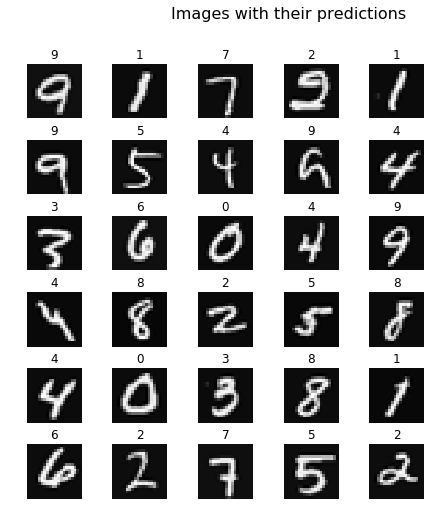

In [13]:
X,Y,m = ReadData('ImageDS.txt',',')
Y = Y.astype(int)
original_X = X
X = AddOnes(X)
input_layer_size = X.shape[1]
hidden_layer_size = 25

options = {'disp': False, 'maxiter':2}
train = True

plt_X = original_X[np.random.randint(X.shape[0], size=30),:]
labels = np.unique(Y)
total_labels = len(labels)

print(f'There are a total of {total_labels} labels, which are : {labels}\n')

Theta1 = np.random.rand(hidden_layer_size, input_layer_size)
Theta2 = np.random.rand(total_labels, hidden_layer_size + 1)

fname = "all_theta.pickle"

if os.path.isfile(fname):
    pickle_in = open(fname,"rb")
    [ Theta1,Theta2 ] = pickle.load(pickle_in)
    pickle_in.close()
    
all_theta = np.concatenate((np.ravel(Theta1),np.ravel(Theta2)))

#print(Theta1.shape,Theta2.shape,all_theta.shape)
lambd = 1

initial_theta = np.squeeze(all_theta)

J,grad = CostCalc(initial_theta,X,Y,m,lambd,total_labels,input_layer_size,hidden_layer_size)

print('Doing Grad Descent Check\n')

params,verbose = 5, False
Numgrad = GradientDescentCheck(initial_theta,X,Y,m,lambd,total_labels,input_layer_size,hidden_layer_size,params,verbose)

print('Gradients from analytical method\n')
print(grad[0:5])
print('\nGradients from numerical method\n')
print(Numgrad[0:5])
score = abs(sum(Numgrad[0:5]-grad[0:5]))
print(f'\nGradients difference between numerical and analytical method = {score}\n')


if train:
    
    iterations = options['maxiter']
    print(f'Starting Training with {iterations} iterations\n')
    initial_theta = np.squeeze(all_theta)
    Result = op.minimize(fun = CostCalc, x0 = initial_theta, args = (X,Y,m,lambd,total_labels,input_layer_size,hidden_layer_size),
                         method = 'Newton-CG', jac = True, options=options)
    cost = Result.fun
    trained_theta = Result.x
    theta = trained_theta
    print(f"\nThe cost is {cost} and it's success is {Result.success} with the message '{Result.message}'\n")
    Theta1 = np.array(theta[0:hidden_layer_size * input_layer_size]).reshape(hidden_layer_size,input_layer_size)
    Theta2 = np.array(theta[hidden_layer_size * input_layer_size:len(theta)]).reshape(total_labels,hidden_layer_size + 1)
    pickle_out = open(fname,"wb")
    pickle.dump([Theta1,Theta2], pickle_out)
    pickle_out.close()
    
    print('Training Done!\n')
#raise SystemExit(0)
P = Predict(Theta1,Theta2, X)
##error = (1/m) * sum(np.abs(P-Y)) * 100
##Accuracy = 100 - error
Accuracy = np.mean(Y == P) * 100
print(f'Accuracy on training data = {Accuracy} %\n')

P = Predict(Theta1,Theta2,AddOnes(plt_X))
P = np.squeeze(P)
ShowImages(plt_X,P,gray=True)